# To predict whether a person makes over50K per year or not from classic adult dataset using XGBoost.
The
description of the dataset is as follows:
Data Set Information:
Extraction was done by Barry Becker from the 1994 Census
database. A set of reasonably clean records was extracted using the
following conditions: ((AAGE>16) && (AGI>100) &&
(AFNLWGT>1)&& (HRSWK>0))

Attribute Information:
Listing of attributes: >50K, <=50K.
age: continuous.
workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,
Local-gov, State-gov, Without-pay, Never-worked.
fnlwgt: continuous.
education: Bachelors, Some-college, 11th, HS-grad, Prof-school,
Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th,
Doctorate, 5th-6th, Preschool.
education-num: continuous.

marital-status: Married-civ-spouse, Divorced, Never-married,
Separated, Widowed, Married-spouse-absent, Married-AF-spouse.

occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-
managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct,

Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv,
Protective-serv, Armed-Forces.
relationship: Wife, Own-child, Husband, Not-in-family, Other-relative,
Unmarried.
race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
sex: Female, Male.
capital-gain: continuous.
capital-loss: continuous.
hours-per-week: continuous.
native-country: United-States, Cambodia, England, Puerto-Rico,
Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan,
Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy,
Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France,
Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia,

Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-
Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.



In [80]:
import numpy as np
import pandas as pd
import ppscore as pps
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [81]:

train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
                        
                        
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain',
'capital_loss', 'hours_per_week', 'native_country', 'wage_class']
                       
train_set.columns = col_labels
test_set.columns = col_labels

In [82]:
train_set.tail()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [83]:
train_set.shape

(32561, 15)

In [84]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
wage_class        32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [85]:
for d in train_set.columns:
    print("{} Unique Values".format(d))
    print("{}".format(train_set[d].unique()),"\n")

age Unique Values
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87] 

workclass Unique Values
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked'] 

fnlwgt Unique Values
[ 77516  83311 215646 ...  34066  84661 257302] 

education Unique Values
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th'] 

education_num Unique Values
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8] 

marital_status Unique Values
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed'] 

occupation Unique Values
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' 

In [86]:
train_set["native_country"] = train_set["native_country"].apply(str.strip).replace("?",np.nan)
liste_1 =train_set["native_country"]
for i in range(0,len(liste_1)):
    if pd.isnull(liste_1[i]):
        liste_1[i] = liste_1[i-1]
        
train_set["native_country"].unique()        
                

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


array(['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico', 'South',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [87]:
train_set["occupation"] = train_set["occupation"].apply(str.strip).replace("?",np.nan)
liste_2 =train_set["occupation"]

for i in range(0,len(liste_2)):
    if pd.isnull(liste_2[i]):
        liste_2[i] = liste_2[i-1]
        
train_set["occupation"].unique()       

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [88]:
train_set["workclass"] = train_set["workclass"].apply(str.strip).replace("?",np.nan)
liste_3 =train_set["workclass"]

for i in range(0,len(liste_3)):
    if pd.isnull(liste_3[i]):
        liste_3[i] = liste_3[i-1]
        
train_set["workclass"].unique()       

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

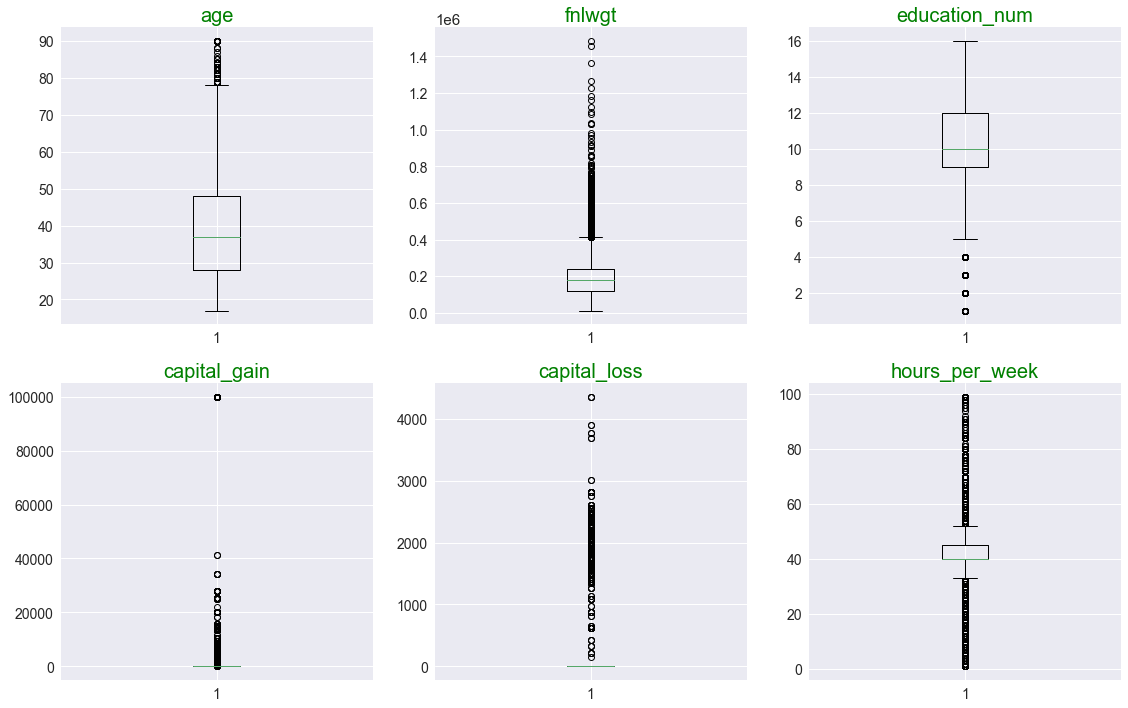

In [89]:
plt.figure(figsize=(19,12))


num_feat = train_set.select_dtypes(include=['int64']).columns

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.boxplot(train_set[num_feat[i]])
    plt.title(num_feat[i],color="g",fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)


plt.show()

In [90]:
from scipy.stats.mstats import winsorize
train_set["age"]           = winsorize(train_set["age"],(0,0.15))
train_set["fnlwgt"]        = winsorize(train_set["fnlwgt"],(0,0.15))
train_set["capital_gain"]  = winsorize(train_set["capital_gain"],(0,0.099))
train_set["capital_loss"]  = winsorize(train_set["capital_loss"],(0,0.099))
train_set["hours.per.week"]= winsorize(train_set["hours_per_week"],(0.12,0.18))

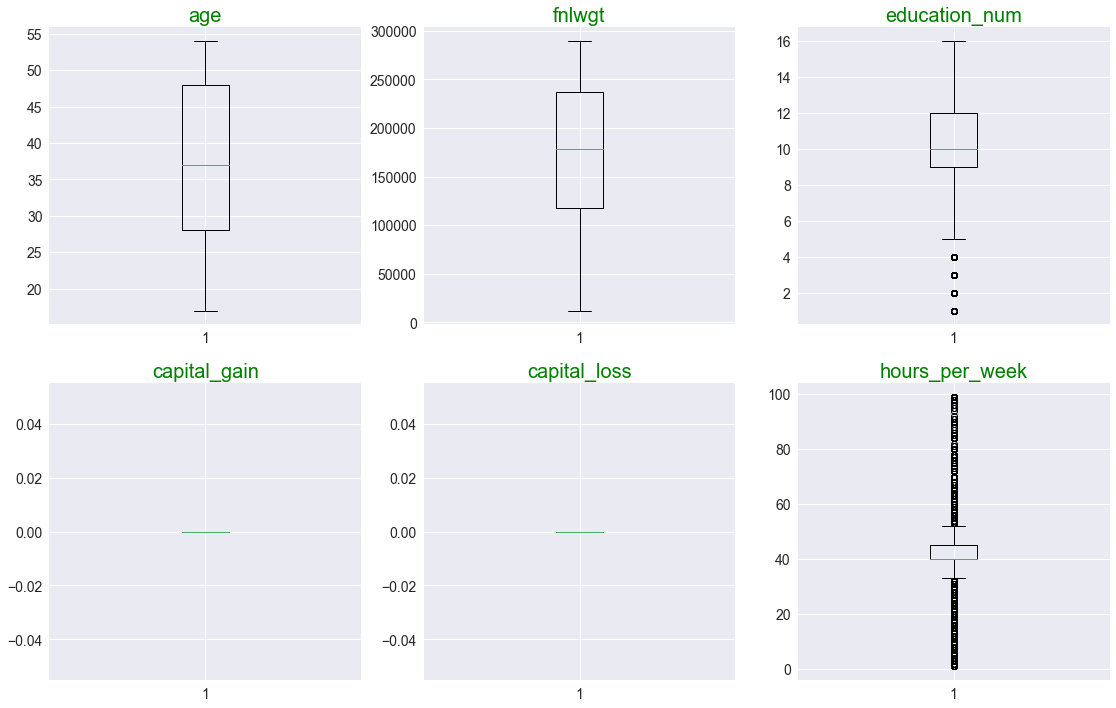

In [91]:
plt.figure(figsize=(19,12))


num_feat = train_set.select_dtypes(include=['int64']).columns

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.boxplot(train_set[num_feat[i]])
    plt.title(num_feat[i],color="g",fontsize=20)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)


plt.show()

In [92]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()


In [93]:
train_set['sex'] = labelencoder.fit_transform(train_set['sex'])


In [94]:
train_set['wage_class'] = labelencoder.fit_transform(train_set['wage_class'])

In [95]:
train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class,hours.per.week
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,1,0,0,40,United-States,0,40
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,1,0,0,13,United-States,0,25
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,1,0,0,40,United-States,0,40
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,1,0,0,40,United-States,0,40
4,28,Private,289405,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,0,0,0,40,Cuba,0,40


In [96]:
train_set1 = pd.get_dummies(train_set['workclass'])
train_set2 = pd.get_dummies(train_set["education"])
train_set3 = pd.get_dummies(train_set["marital_status"])
train_set4 = pd.get_dummies(train_set["occupation"])
train_set5 = pd.get_dummies(train_set["relationship"])
train_set6 = pd.get_dummies(train_set["race"])
train_set7 = pd.get_dummies(train_set["native_country"])

train_set  = pd.concat([train_set,train_set1,train_set2,train_set3,train_set4,train_set5,train_set6,train_set7],axis=1)

In [97]:
train_set.drop(['workclass','education','marital_status','occupation', 'relationship','race','native_country' ] , axis = 1, inplace = True)


In [98]:
train_set.shape

(32561, 106)

In [99]:
y = train_set['wage_class']
X = train_set.drop('wage_class' , axis = 1)

In [100]:
# as the datapoints differ a lot in magnitude, we'll scale them
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(X)

In [101]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(scaled_data,y,test_size=0.3,random_state=42)

In [102]:
# fit model no training data
model = XGBClassifier(objective='binary:logistic')
model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [103]:
# cheking training accuracy
y_pred = model.predict(train_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_y,predictions)
accuracy

0.8434538434538434

In [104]:
# cheking initial test accuracy
y_pred = model.predict(test_x)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(test_y,predictions)
accuracy

0.8442010441191524

In [105]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(test_y, y_pred) 
 
print ('Confusion Matrix:')
print(results) 


Confusion Matrix:
[[6963  492]
 [1030 1284]]


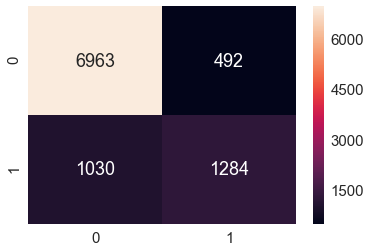

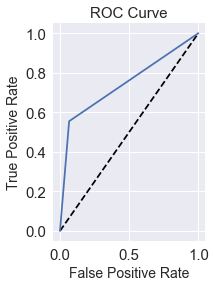


 
 AUC  :  0.744443671536566


In [106]:
fpr, tpr, thresholds  = roc_curve(test_y,y_pred )

#Plot the confusion matrix

sns.set(font_scale=1.5)
cm = confusion_matrix(test_y, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


# Plot ROC curve
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC Curve',fontsize=15)
plt.show()
print("\n","\n",'AUC  : ', roc_auc_score(test_y,y_pred ))

In [107]:
# Now to increae the accuracy of the model, we'll do hyperparameter tuning using grid search

In [108]:
from sklearn.model_selection import GridSearchCV

In [109]:
param_grid={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators"     : [10,50,100,200,500, 800, 1000]   
}


In [110]:
grid= GridSearchCV(XGBClassifier(objective='binary:logistic'),param_grid, verbose=3)

In [ ]:
grid.fit(train_x,train_y)

Fitting 5 folds for each of 26880 candidates, totalling 134400 fits
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10, score=0.803, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10, score=0.798, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10, score=0.799, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10, score=0.802, total=   0.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=10, score=0.803, total=   0.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50, score=0.826, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10, score=0.798, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10, score=0.799, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10, score=0.802, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=10, score=0.803, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10, score=0.803, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10, score=0.798, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10, score=0.799, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10, score=0.802, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=1000, score=0.841, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10, score=0.803, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10, score=0.798, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10, score=0.799, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, score=0.847, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=1000, score=0.843, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=10, score=0.811, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=10, score=0.814, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1000, score=0.835, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1000, score=0.847, total= 1.9min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=1000, score=0.838, total= 2.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=10, score=0.812, total=   1.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsampl

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, score=0.846, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, score=0.839, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, score=0.849, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=1000, score=0.837, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  cols

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.840, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.845, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.837, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.848, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=1000 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=800, score=0.840, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.838, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.842, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.839, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  col

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=800, score=0.845, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=800, score=0.837, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.841, total= 1.8min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.841, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsa

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=800, score=0.837, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=800, score=0.849, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=800, score=0.837, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.839, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsamp

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800, score=0.841, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800, score=0.838, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800, score=0.849, total= 1.8min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=800, score=0.840, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800, score=0.839, total= 2.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800, score=0.841, total= 1.9min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800, score=0.836, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800, score=0.849, total= 1.9min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=500, score=0.839, total=  55.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800, score=0.841, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800, score=0.841, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800, score=0.835, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, score=0.849, total=  56.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=500, score=0.838, total=  55.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=800, score=0.840, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=800, score=0.842, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, score=0.838, total=  59.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, score=0.849, total=  58.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=500, score=0.840, total=  58.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=800, score=0.839, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, score=0.844, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, score=0.837, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, score=0.848, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=500, score=0.840, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500, score=0.842, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500, score=0.842, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500, score=0.836, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500, score=0.848, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=200, score=0.838, total=  36.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500, score=0.841, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500, score=0.839, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500, score=0.837, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200, score=0.849, total=  35.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=200, score=0.839, total=  36.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=500, score=0.839, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=500, score=0.838, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200, score=0.841, total=  49.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200, score=0.849, total=  41.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=200, score=0.839, total=  47.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500, score=0.837, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, score=0.842, total=  43.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, score=0.837, total=  44.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, score=0.849, total=  44.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200, score=0.839, total=  46.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, score=0.841, total=  42.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, score=0.839, total=  41.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, score=0.839, total=  43.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200, score=0.850, total=  41.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=100, score=0.841, total=  23.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200, score=0.841, total=  41.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200, score=0.843, total=  41.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200, score=0.840, total=  42.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=100, score=0.845, total=  28.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=100, score=0.840, total=  31.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=200, score=0.841, total=  56.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=200, score=0.841, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=100, score=0.838, total=  36.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=100, score=0.843, total=  35.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=100, score=0.838, total=  34.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=200, score=0.840, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100, score=0.839, total=  31.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100, score=0.838, total=  30.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100, score=0.845, total=  30.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=100, score=0.838, total=  30.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100, score=0.840, total=  23.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100, score=0.839, total=  23.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100, score=0.837, total=  23.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100, score=0.843, total=  22.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=100 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=50, score=0.836, total=  11.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100, score=0.841, total=  23.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100, score=0.841, total=  24.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100, score=0.839, total=  23.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  col

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=50, score=0.839, total=  14.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=50, score=0.837, total=  14.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=100, score=0.839, total=  27.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=100, score=0.840, total=  27.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsa

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=50, score=0.833, total=  13.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=50, score=0.837, total=  13.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=50, score=0.837, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=100, score=0.841, total=  27.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsamp

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50, score=0.838, total=  13.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50, score=0.834, total=  13.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50, score=0.838, total=  12.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=50, score=0.838, total=  13.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50, score=0.838, total=  12.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50, score=0.840, total=  12.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50, score=0.830, total=  14.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50, score=0.838, total=  12.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=50 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=10, score=0.805, total=   1.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, score=0.833, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, score=0.835, total=   5.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50, score=0.831, total=   5.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=10, score=0.806, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=10, score=0.805, total=   1.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, score=0.833, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50, score=0.836, total=   5.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=10, score=0.812, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=10, score=0.806, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=10, score=0.805, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50, score=0.833, total=   5.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10, score=0.809, total=   1.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10, score=0.812, total=   1.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10, score=0.806, total=   1.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=10, score=0.805, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10, score=0.818, total=   1.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10, score=0.818, total=   1.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10, score=0.818, total=   1.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10, score=0.817, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=1000, score=0.837, total= 2.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10, score=0.818, total=   1.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10, score=0.818, total=   1.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10, score=0.818, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, ga

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, score=0.848, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=1000, score=0.837, total= 3.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10, score=0.818, total=   1.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10, score=0.818, total=   1.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.835, total= 5.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.850, total= 5.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.837, total= 7.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=10, score=0.818, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.837, total= 5.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.838, total= 5.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.846, total= 5.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.837, total= 5.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.838, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.832, total= 2.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.828, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.842, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=800, score=0.836, total= 1.9min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.838, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.833, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.831, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_b

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=800, score=0.845, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=800, score=0.837, total= 1.8min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.840, total= 2.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.836, total= 2.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_byt

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=800, score=0.834, total= 1.8min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=800, score=0.847, total= 2.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=800, score=0.837, total= 2.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.841, total= 2.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytre

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800, score=0.831, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800, score=0.830, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800, score=0.847, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=800, score=0.832, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800, score=0.838, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800, score=0.831, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800, score=0.830, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800, score=0.847, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=500, score=0.834, total=  58.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800, score=0.836, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800, score=0.835, total= 1.8min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800, score=0.832, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, score=0.850, total=  59.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=500, score=0.837, total=  58.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=800, score=0.835, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=800, score=0.839, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, score=0.829, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, score=0.842, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, score=0.830, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=800, score=0.835, total= 1.8min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500, score=0.830, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500, score=0.828, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500, score=0.845, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=500, score=0.832, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, score=0.839, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, score=0.832, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, score=0.833, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500, score=0.847, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=200, score=0.839, total=  25.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500, score=0.836, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500, score=0.836, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500, score=0.831, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=200, score=0.844, total=  30.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=200, score=0.838, total=  42.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, score=0.835, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500, score=0.830, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=200, score=0.833, total=  29.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=200, score=0.846, total=  29.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=200, score=0.832, total=  28.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=500, score=0.838, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, score=0.839, total=  55.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, score=0.834, total=  45.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, score=0.846, total=  53.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=200, score=0.836, total=  54.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200, score=0.838, total=  44.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200, score=0.838, total=  31.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200, score=0.837, total=  30.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200, score=0.849, total=  30.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=100, score=0.837, total=  25.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200, score=0.841, total=  35.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200, score=0.834, total=  34.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200, score=0.837, total=  34.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=100, score=0.846, total=  27.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=100, score=0.841, total=  37.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=200, score=0.839, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=200, score=0.836, total=  34.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=100, score=0.835, total=  18.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=100, score=0.847, total=  16.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=100, score=0.839, total=  17.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=200, score=0.839, total=  32.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100, score=0.839, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100, score=0.838, total=  12.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100, score=0.848, total=  12.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=100, score=0.839, total=  12.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100, score=0.837, total=  15.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100, score=0.837, total=  15.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100, score=0.834, total=  15.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100, score=0.846, total=  16.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=50, score=0.839, total=   7.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100, score=0.841, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100, score=0.835, total=  14.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100, score=0.833, total=  15.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_b

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=50, score=0.843, total=   8.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=50, score=0.841, total=   7.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=100, score=0.840, total=  14.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=100, score=0.835, total=  20.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_byt

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=50, score=0.838, total=   7.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=50, score=0.842, total=   7.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=50, score=0.840, total=   7.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=100, score=0.840, total=  14.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytre

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50, score=0.840, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50, score=0.832, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50, score=0.838, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=50, score=0.830, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50, score=0.834, total=   3.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50, score=0.839, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50, score=0.832, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50, score=0.835, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=10, score=0.816, total=   0.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50, score=0.834, total=   3.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50, score=0.841, total=   3.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50, score=0.834, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=10, score=0.815, total=   0.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=10, score=0.816, total=   0.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=50, score=0.835, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=50, score=0.840, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=10, score=0.821, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=10, score=0.822, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=10, score=0.824, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=50, score=0.835, total=   3.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10, score=0.819, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10, score=0.821, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10, score=0.821, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=10, score=0.824, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10, score=0.823, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10, score=0.819, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10, score=0.821, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10, score=0.822, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=5, n_estimators=1000, score=0.831, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10, score=0.823, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10, score=0.820, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10, score=0.820, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.845, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=4, min_child_weight=7, n_estimators=1000, score=0.836, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=10, score=0.823, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=10, score=0.823, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.828, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.843, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.831, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=10, score=0.823, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsampl

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.828, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.845, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.829, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  cols

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.836, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.826, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.842, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=800, score=0.832, total=  57.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.839, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.830, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  col

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=800, score=0.841, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=800, score=0.828, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.836, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.828, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsa

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=800, score=0.829, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=800, score=0.841, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=800, score=0.825, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.832, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsamp

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800, score=0.830, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800, score=0.832, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800, score=0.843, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=800, score=0.826, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800, score=0.834, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800, score=0.832, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800, score=0.833, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800, score=0.844, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=500, score=0.824, total=  46.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800, score=0.830, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800, score=0.832, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800, score=0.823, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500, score=0.843, total=  53.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=500, score=0.826, total=  46.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=800, score=0.832, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=800, score=0.823, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500, score=0.828, total=  45.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500, score=0.847, total=  45.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=500, score=0.826, total=  45.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=800, score=0.831, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500, score=0.834, total=  45.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500, score=0.831, total=  45.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500, score=0.845, total=  46.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=500, score=0.829, total=  46.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500, score=0.831, total=  53.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500, score=0.825, total=  53.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500, score=0.821, total=  53.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500, score=0.838, total=  53.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=200, score=0.828, total=  21.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500, score=0.830, total=  52.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500, score=0.828, total=  51.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500, score=0.826, total=  51.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=200, score=0.849, total=  21.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=200, score=0.831, total=  20.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=500, score=0.834, total=  52.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=500, score=0.827, total=  52.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=200, score=0.831, total=  21.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=200, score=0.849, total=  21.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=200, score=0.836, total=  21.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=500, score=0.836, total=  52.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200, score=0.832, total=  24.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200, score=0.825, total=  24.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200, score=0.842, total=  25.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=200, score=0.830, total=  24.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200, score=0.831, total=  23.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200, score=0.833, total=  24.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200, score=0.825, total=  23.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200, score=0.846, total=  24.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=100, score=0.835, total=  12.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200, score=0.836, total=  23.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200, score=0.834, total=  25.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200, score=0.831, total=  23.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=100, score=0.851, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=100, score=0.840, total=  12.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=200, score=0.835, total=  24.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=200, score=0.833, total=  24.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=100, score=0.830, total=  14.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=100, score=0.844, total=  15.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=100, score=0.832, total=  15.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=200, score=0.832, total=  28.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100, score=0.835, total=  14.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100, score=0.832, total=  14.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100, score=0.848, total=  15.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=100, score=0.832, total=  15.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100, score=0.840, total=  14.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100, score=0.836, total=  15.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100, score=0.835, total=  13.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100, score=0.846, total=  14.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=50, score=0.841, total=   6.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100, score=0.839, total=  14.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100, score=0.832, total=  13.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100, score=0.833, total=  13.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  col

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=50, score=0.838, total=   3.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=50, score=0.835, total=   4.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, score=0.839, total=   6.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, score=0.845, total=   6.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3,

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, score=0.837, total=   2.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, score=0.838, total=   2.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=50, score=0.837, total=   2.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100, score=0.840, total=   5.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, g

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, score=0.843, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, score=0.837, total=   3.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, score=0.838, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=50, score=0.835, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gam

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50, score=0.834, total=   2.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50, score=0.843, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50, score=0.835, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50, score=0.839, total=   3.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=10, score=0.828, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50, score=0.834, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50, score=0.841, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50, score=0.838, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=10, score=0.831, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=10, score=0.827, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=50, score=0.836, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=50, score=0.841, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=10, score=0.824, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=10, score=0.831, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=10, score=0.827, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=50, score=0.837, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10, score=0.823, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10, score=0.823, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10, score=0.830, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=10, score=0.827, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10, score=0.828, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10, score=0.825, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10, score=0.824, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10, score=0.829, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=1, n_estimators=1000, score=0.823, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10, score=0.829, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10, score=0.826, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10, score=0.823, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, ga

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.839, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, n_estimators=1000, score=0.823, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=10, score=0.829, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=10, score=0.825, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.826, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.840, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.823, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=10, score=0.830, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.831, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.828, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.838, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.825, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.829, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.819, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.824, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=800, score=0.826, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.830, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.826, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.824, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_b

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=800, score=0.844, total=  58.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=800, score=0.824, total=  58.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.831, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.825, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_byt

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=800, score=0.828, total=  58.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=800, score=0.841, total=  58.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=800, score=0.827, total=  59.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.832, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytre

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800, score=0.824, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800, score=0.822, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=800, score=0.818, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, score=0.825, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, score=0.825, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, score=0.821, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800, score=0.837, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=500, score=0.823, total=  42.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800, score=0.829, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800, score=0.826, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800, score=0.821, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=500, score=0.841, total=  43.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=500, score=0.825, total=  43.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=800, score=0.834, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=800, score=0.826, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=500, score=0.818, total=  51.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=500, score=0.835, total=  51.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=500, score=0.814, total=  51.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=800, score=0.827, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500, score=0.823, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500, score=0.822, total=  52.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500, score=0.837, total=  51.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=500, score=0.821, total=  51.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500, score=0.833, total=  51.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500, score=0.826, total=  53.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500, score=0.826, total=  51.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500, score=0.835, total=  53.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=200, score=0.832, total=  21.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500, score=0.835, total=  50.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500, score=0.826, total=  51.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500, score=0.823, total=  51.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=200, score=0.840, total=  23.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=200, score=0.825, total=  24.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=500, score=0.828, total=  59.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=500, score=0.819, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=200, score=0.824, total=  23.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=200, score=0.844, total=  23.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=200, score=0.822, total=  23.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=500, score=0.825, total=  57.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200, score=0.830, total=  24.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200, score=0.827, total=  23.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200, score=0.846, total=  23.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=200, score=0.826, total=  24.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200, score=0.834, total=  23.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200, score=0.833, total=  23.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200, score=0.825, total=  23.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200, score=0.846, total=  23.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=100, score=0.824, total=  15.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200, score=0.834, total=  28.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200, score=0.828, total=  29.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200, score=0.822, total=  28.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=100, score=0.844, total=  14.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=100, score=0.828, total=  14.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=200, score=0.833, total=  28.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=200, score=0.827, total=  28.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=100, score=0.829, total=  13.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=100, score=0.850, total=  13.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=100, score=0.825, total=  13.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=200, score=0.834, total=  28.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100, score=0.837, total=  14.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100, score=0.833, total=  13.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100, score=0.845, total=  14.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=100, score=0.830, total=  13.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100, score=0.838, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100, score=0.846, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100, score=0.842, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100, score=0.845, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=50, score=0.841, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100, score=0.841, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100, score=0.846, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100, score=0.841, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_b

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=50, score=0.842, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=50, score=0.839, total=   3.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=100, score=0.840, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=100, score=0.846, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_byt

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=50, score=0.839, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=50, score=0.841, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=50, score=0.837, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=100, score=0.840, total=   5.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytre

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50, score=0.844, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50, score=0.839, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50, score=0.843, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=50, score=0.837, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50, score=0.839, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50, score=0.845, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50, score=0.843, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50, score=0.844, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=10, score=0.827, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50, score=0.838, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50, score=0.844, total=   3.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50, score=0.840, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=10, score=0.830, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=10, score=0.827, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=50, score=0.837, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=50, score=0.845, total=   3.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=10, score=0.824, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=10, score=0.833, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=10, score=0.830, total=   0.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=50, score=0.839, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10, score=0.828, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10, score=0.824, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10, score=0.831, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=10, score=0.829, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10, score=0.833, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10, score=0.828, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10, score=0.825, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10, score=0.831, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=5, n_estimators=1000, score=0.823, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10, score=0.831, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10, score=0.827, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10, score=0.824, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.841, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=5, min_child_weight=7, n_estimators=1000, score=0.823, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=10, score=0.830, total=   1.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=10, score=0.828, total=   1.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.821, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.828, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.817, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=10, score=0.830, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsampl

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.821, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.824, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.835, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.816, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  cols

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.828, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.825, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.826, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.837, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=800, score=0.816, total=  59.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.830, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.827, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.828, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  col

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=800, score=0.831, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=800, score=0.813, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.821, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.824, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsa

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=800, score=0.824, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=800, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=800, score=0.815, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.822, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsamp

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800, score=0.827, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800, score=0.823, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=800, score=0.817, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800, score=0.827, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800, score=0.825, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800, score=0.825, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=500, score=0.818, total=  51.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800, score=0.825, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800, score=0.825, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800, score=0.815, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=500, score=0.833, total=  50.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=500, score=0.817, total=  51.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=800, score=0.820, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=800, score=0.819, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=500, score=0.822, total=  50.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=500, score=0.836, total=  50.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=500, score=0.821, total=  51.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=800, score=0.829, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500, score=0.829, total=  51.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500, score=0.823, total=  50.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500, score=0.840, total=  50.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=500, score=0.819, total=  50.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500, score=0.826, total=  59.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500, score=0.825, total=  59.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500, score=0.817, total=  59.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500, score=0.826, total=  58.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=200, score=0.824, total=  23.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500, score=0.822, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500, score=0.823, total=  58.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500, score=0.821, total=  58.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=200, score=0.838, total=  23.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=200, score=0.817, total=  23.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=500, score=0.825, total=  58.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=500, score=0.825, total=  57.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=200, score=0.827, total=  23.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=200, score=0.841, total=  25.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=200, score=0.825, total=  24.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=500, score=0.826, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200, score=0.824, total=  29.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200, score=0.826, total=  29.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200, score=0.832, total=  29.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=200, score=0.822, total=  35.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200, score=0.829, total=  27.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200, score=0.824, total=  28.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200, score=0.823, total=  34.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200, score=0.832, total=  29.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=100, score=0.832, total=  15.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200, score=0.829, total=  29.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200, score=0.826, total=  28.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200, score=0.820, total=  29.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=100, score=0.849, total=  13.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=100, score=0.825, total=  13.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=200, score=0.830, total=  27.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=200, score=0.830, total=  26.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.25, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, score=0.838, total=   9.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, score=0.843, total=   9.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=100, score=0.838, total=   7.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200, score=0.839, total=  16.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, score=0.845, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, score=0.839, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, score=0.843, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=100, score=0.840, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100, score=0.839, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100, score=0.842, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100, score=0.840, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100, score=0.846, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=50, score=0.839, total=   2.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100, score=0.836, total=   6.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100, score=0.841, total=   5.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100, score=0.841, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=50, score=0.846, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=50, score=0.834, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, score=0.837, total=   6.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100, score=0.843, total=   6.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3,

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50, score=0.840, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50, score=0.844, total=   3.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=50, score=0.839, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=100, score=0.840, total=   7.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, g

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50, score=0.843, total=   3.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50, score=0.839, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50, score=0.846, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=50, score=0.836, total=   3.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gam

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50, score=0.839, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50, score=0.843, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50, score=0.843, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50, score=0.844, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=10, score=0.833, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50, score=0.838, total=   3.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50, score=0.843, total=   3.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50, score=0.837, total=   3.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=10, score=0.832, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=10, score=0.831, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=50, score=0.838, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=50, score=0.842, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=10, score=0.828, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=10, score=0.832, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=10, score=0.830, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=50, score=0.840, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10, score=0.827, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10, score=0.828, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10, score=0.832, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=10, score=0.830, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=5, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10, score=0.834, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10, score=0.830, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10, score=0.830, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10, score=0.834, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamm

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=1000, score=0.813, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10, score=0.834, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10, score=0.832, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10, score=0.831, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, ga

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=1000, score=0.814, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=10, score=0.834, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=10, score=0.830, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.822, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.836, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.819, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=10, score=0.834, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.826, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.824, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.819, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.822, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.818, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.812, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.824, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=800, score=0.817, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.818, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.817, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.815, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_b

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=800, score=0.833, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=800, score=0.817, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=1000, score=0.821, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=1000, score=0.819, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample_byt

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=800, score=0.821, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=800, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=800, score=0.816, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=1000, score=0.826, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=8, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytre

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800, score=0.821, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800, score=0.814, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800, score=0.826, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=800, score=0.810, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=1000 
[CV]  colsample

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800, score=0.817, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800, score=0.818, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800, score=0.814, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800, score=0.830, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=500, score=0.815, total=  51.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800, score=0.823, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800, score=0.824, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800, score=0.819, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=500, score=0.828, total=  50.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=500, score=0.815, total=  51.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800, score=0.821, total= 1.3min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800, score=0.816, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=500, score=0.817, total=  59.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=500, score=0.830, total=  58.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=500, score=0.812, total=  58.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=800, score=0.826, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=1, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500, score=0.816, total=  59.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500, score=0.814, total=  58.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500, score=0.827, total=  59.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=500, score=0.812, total=  58.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=3, n_estimators=800 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500, score=0.822, total=  58.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500, score=0.822, total=  58.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500, score=0.819, total=  58.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500, score=0.833, total=  57.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=200, score=0.821, total=  23.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500, score=0.824, total=  57.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500, score=0.819, total=  59.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500, score=0.817, total=  57.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=200, score=0.832, total=  28.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=200, score=0.823, total=  28.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=500, score=0.821, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=500, score=0.819, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=200, score=0.821, total=  37.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=200, score=0.833, total=  27.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=200, score=0.820, total=  27.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=500, score=0.819, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200, score=0.825, total=  28.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200, score=0.821, total=  27.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200, score=0.832, total=  28.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=200, score=0.820, total=  28.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=5, n_estimators=500 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200, score=0.828, total=  35.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200, score=0.826, total=  27.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200, score=0.820, total=  27.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200, score=0.839, total=  27.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.3, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100, score=0.832, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, score=0.835, total=  10.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, score=0.842, total=  11.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200, score=0.836, total=  11.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, score=0.831, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=100, score=0.830, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, score=0.835, total=  11.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200, score=0.842, total=  10.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, score=0.830, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, score=0.830, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=100, score=0.831, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200, score=0.835, total=  10.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=5, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, score=0.834, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, score=0.830, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, score=0.831, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=100, score=0.831, total=   5.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, score=0.835, total=   6.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, score=0.835, total=   6.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, score=0.834, total=   6.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100, score=0.834, total=   6.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=50, score=0.828, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, score=0.835, total=   6.7s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, score=0.834, total=   6.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100, score=0.833, total=   6.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_b

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=50, score=0.831, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=50, score=0.828, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100, score=0.836, total=   6.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100, score=0.837, total=   6.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=5, n_estimators=100 
[CV]  colsample_byt

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=50, score=0.827, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=50, score=0.831, total=   3.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=50, score=0.828, total=   3.4s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100, score=0.835, total=   6.7s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=4, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytre

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50, score=0.829, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50, score=0.830, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50, score=0.834, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=50, score=0.829, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, score=0.831, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, score=0.830, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, score=0.830, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50, score=0.833, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=10, score=0.816, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50, score=0.831, total=   3.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50, score=0.829, total=   3.7s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50, score=0.830, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=5, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=10, score=0.813, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=10, score=0.815, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=50, score=0.832, total=   3.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=50, score=0.831, total=   3.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=7, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=10, score=0.816, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=10, score=0.820, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=10, score=0.820, total=   1.4s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=50, score=0.834, total=   4.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=1, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10, score=0.820, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10, score=0.814, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10, score=0.821, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=10, score=0.820, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=50 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10, score=0.820, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10, score=0.821, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10, score=0.815, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10, score=0.821, total=   0.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=10 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=5, n_estimators=1000, score=0.837, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10, score=0.820, total=   1.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10, score=0.820, total=   1.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10, score=0.815, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=10 
[CV]  colsample_bytree

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.846, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=6, min_child_weight=7, n_estimators=1000, score=0.838, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=10, score=0.825, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=10, score=0.821, total=   1.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=10 
[CV]  colsample_by

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.830, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.846, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=1, n_estimators=1000, score=0.834, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=10 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=10, score=0.823, total=   1.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=10 
[CV]  colsampl

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.833, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.831, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.848, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=3, n_estimators=1000, score=0.833, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=10 
[CV]  cols

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000, score=0.839, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000, score=0.834, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000, score=0.836, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000, score=0.850, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=5, n_estimators=1000 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=800, score=0.835, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000, score=0.836, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000, score=0.835, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000, score=0.835, total= 1.5min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=8, min_child_weight=7, n_estimators=1000 
[CV]  col

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=800, score=0.843, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=800, score=0.832, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=1000, score=0.837, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=1000, score=0.832, total= 2.0min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=1000 
[CV

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=800, score=0.831, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=800, score=0.843, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=800, score=0.831, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1000 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1000, score=0.835, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=1000 
[CV] 

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800, score=0.834, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800, score=0.831, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800, score=0.849, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=800, score=0.829, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=5, n_estimators=1000 
[CV]  c

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800, score=0.835, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800, score=0.835, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800, score=0.833, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800, score=0.847, total= 1.4min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=10, min_child_weight=7, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=500, score=0.832, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800, score=0.838, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800, score=0.831, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800, score=0.828, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=500, score=0.846, total=  58.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=500, score=0.831, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=800, score=0.835, total= 1.7min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=800, score=0.830, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=500, score=0.833, total=  59.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=500, score=0.846, total=  59.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=500, score=0.832, total= 1.0min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=800 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=800, score=0.836, total= 1.6min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=5, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500, score=0.837, total=  58.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500, score=0.833, total=  58.4s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500, score=0.850, total=  59.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=500, score=0.832, total=  58.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=7, n_estimators=800 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500, score=0.835, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500, score=0.827, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500, score=0.842, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=1, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=200, score=0.836, total=  28.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500, score=0.838, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500, score=0.835, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500, score=0.830, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=3, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=200, score=0.847, total=  28.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=200, score=0.836, total=  27.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=500, score=0.837, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=500, score=0.834, total= 1.2min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=5, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=200, score=0.834, total=  27.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=200, score=0.847, total=  27.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=200, score=0.838, total=  27.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=500 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=500, score=0.837, total= 1.1min
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=15, min_child_weight=7, n_estimators=500 
[CV]  co

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, score=0.845, total=  10.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, score=0.841, total=  10.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, score=0.845, total=  11.7s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=200, score=0.839, total=  10.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=500 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, score=0.839, total=  17.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, score=0.844, total=  16.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, score=0.839, total=  17.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200, score=0.846, total=  13.4s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=100, score=0.837, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, score=0.838, total=  11.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, score=0.844, total=  11.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200, score=0.841, total=  11.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=200 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, score=0.841, total=   6.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=100, score=0.835, total=   5.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, score=0.842, total=  11.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200, score=0.845, total=  11.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7, n_estimators=200 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100, score=0.839, total=  10.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100, score=0.843, total=   7.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=100, score=0.838, total=   7.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200, score=0.840, total=  21.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1, n_estimators=200 
[CV]  colsample_bytree=0

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, score=0.842, total=   7.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, score=0.839, total=   6.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, score=0.842, total=   7.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=100, score=0.841, total=   6.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=3, n_estimators=200 
[CV]  colsample_bytree=0

In [ ]:
# To  find the parameters givingmaximum accuracy
grid.best_params_

In [77]:
# Create new model using the same parameters
f new_model=XGBClassifier(learning_rate= 0.001, max_depth= 10, n_estimators= 500)
new_model.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.001,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
              n_estimators=500, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [78]:
y_pred_new = new_model.predict(test_x)
predictions_new = [round(value) for value in y_pred_new]
accuracy_new = accuracy_score(test_y,predictions_new)
accuracy_new

0.8320196540075749

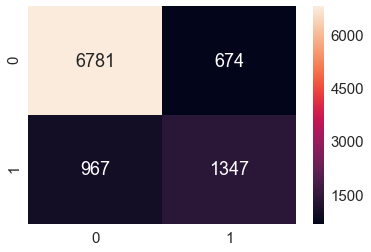

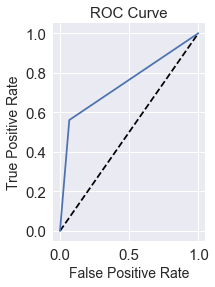


 
 AUC  :  0.7458498904692923


In [79]:
fpr, tpr, thresholds  = roc_curve(test_y,y_pred )
sns.set(font_scale=1.5)
cm = confusion_matrix(test_y, y_pred_new)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()


# Plot ROC curve
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate',fontsize=14)
plt.ylabel('True Positive Rate',fontsize=14)
plt.title('ROC Curve',fontsize=15)
plt.show()
print("\n","\n",'AUC  : ', roc_auc_score(test_y,y_pred_new ))